In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
from functools import partial

import torch
import torch.nn as nn

import sys
sys.path.append("../../")

from baseline.MY_PATHS import *

from baseline.data_creation import wiki_dataset
from baseline.data_creation.preprocess import pad_collate_fn

import baseline.training
from baseline.training import get_train_val_loader, ClassifierLearner

import baseline.model
from baseline.model import FinalModel

import baseline.results_analysis
from baseline.results_analysis import plot_errorbars_by_model, get_mean_std_k

/scratch/mz2476/miniconda3/envs/wiki/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/scratch/mz2476/miniconda3/envs/wiki/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/scratch/mz2476/miniconda3/envs/wiki/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/scratch/mz2476/min

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

# Monolingual (en)

## Load the data

In [3]:
# (index_to_word, word_to_index,
#      dict_wiki_tensor_dataset,
#      weights_matrix_ve, classes) = wiki_dataset.get_monolingual_datasets(
#                                                 LANGUAGE="english", 
#                                                 max_num_tokens=1000,
#                                                 SAVE=True, LOAD=False)

In [4]:
# dict_wiki_tensor_dataset["val"] = dict_wiki_tensor_dataset["val_en"]
# dict_wiki_tensor_dataset.keys()

# dict_wiki_tensor_dataset['multilingual_train_en'][1]

## Model

In [5]:
# SAVE_MODEL = False

# batch_size = 8
# lr = 0.01
# num_epochs = 10

# options = {
#     "VOCAB_SIZE": len(index_to_word),
#     "dim_e": weights_matrix_ve.shape[1],
#     "pretrained_embeddings": weights_matrix_ve,
#     "num_layers": 1,
#     "num_classes": len(classes),
#     "mid_features": 150,
#     "dropout_rate": 0.2,
#     "activation": nn.ReLU(),
# }
    
# result = {
#     "optimizer": "Adam", 
#     "num_hidden": options["num_layers"],
#     "dim_hidden": options["mid_features"],
#     "dropout_rate": options["dropout_rate"],
#     "learning_rate": lr,
#     "num_epochs": num_epochs,
# }


# print("\n", result)
# model_name = "en_" + "_".join([str(key) + "_" + str(value) for key, value in result.items()])

# learner = ClassifierLearner(options, model_name, device=device)

# TRAIN_SET_NAME = "monolingual_train_en"

# val_keys = ["val", "val_en"]
# train_loader, dict_val_loader = get_train_val_loader(
#     dict_wiki_tensor_dataset[TRAIN_SET_NAME], 
#     [dict_wiki_tensor_dataset[key] for key in val_keys], 
#     collate_fn=partial(pad_collate_fn, pad_token=word_to_index["<pad>"])
# )

# dict_val_loader = {
#    key : val_loader 
#    for key, val_loader in zip(val_keys, dict_val_loader)
# }

In [6]:
# learner.set_loaders(train_loader, dict_val_loader)
# learner.train_model(num_epochs=10, lr=0.01)

In [7]:
# learner.best_metrics_dict

In [8]:
# batch_size = 8
# lr = 0.01
# num_epochs = 10


    
# result = {
#     "optimizer": "Adam", 
#     "num_hidden": options["num_layers"],
#     "dim_hidden": options["mid_features"],
#     "dropout_rate": options["dropout_rate"],
#     "learning_rate": lr,
#     "num_epochs": num_epochs,
# }



In [9]:
import pandas as pd
from itertools import product
from baseline.training import fit_model_given_options


# CONST
NUM_EPOCHS = 100
LEARNING_RATE = 0.3

# CHANGE
LANGUAGE = "english"
LIST_MAX_NUM_TOKENS = [500, 1000, None]
LIST_NUM_LAYERS     = [1, 2, 3]
LIST_MID_FEATURES   = [50, 150, 250]


list_params_names = ["max_num_tokens", "num_layers", "mid_features"]
list_scores_names = ['precision_macro', 'recall_macro', 'f1_macro',
                     'precision_micro',  'recall_micro', 'f1_micro']
results_df = pd.DataFrame(columns=list_params_names+list_scores_names)
FAILED_LOGS = []

# CALCULATED BASE ON PREVIOUS
EXPERIMENT_NAME = f"20200212_{LANGUAGE}_experiment"


for max_num_tokens in LIST_MAX_NUM_TOKENS:
    (index_to_word, word_to_index,
        dict_wiki_tensor_dataset,
        weights_matrix_ve, classes) = wiki_dataset.get_monolingual_datasets(
                                                    LANGUAGE=LANGUAGE, 
                                                    max_num_tokens=max_num_tokens,
                                                    SAVE=True, LOAD=False)

    options = {
        "VOCAB_SIZE": len(index_to_word),
        "dim_e": weights_matrix_ve.shape[1],
        "pretrained_embeddings": weights_matrix_ve,
#         "num_layers": 1,
        "num_classes": len(classes),
#         "mid_features": 150,
        "dropout_rate": 0.2,
        "activation": nn.ReLU(),
    }


    for num_layers, mid_features in product(LIST_NUM_LAYERS, LIST_MID_FEATURES):
        try:
            options["num_layers"]   = num_layers
            options["mid_features"] = mid_features

            learner = fit_model_given_options(
                options, dict_wiki_tensor_dataset,
                num_epochs=NUM_EPOCHS, lr=LEARNING_RATE,
                pad_idx=word_to_index["<pad>"], device=device,
                TRAIN_SET_NAME="train", 
                VAL_KEYS=["val", "val_en"])

            # appending scores to df
            list_current_params = [max_num_tokens, num_layers, mid_features]
            list_best_metrics = list(learner.best_metrics_dict.values())
            results_df.loc[results_df.shape[0]] = list_current_params + list_best_metrics

            results_df.to_csv(f"../results/{EXPERIMENT_NAME}.csv")
        except:
            FAILED_LOGS.append([max_num_tokens, num_layers, mid_features])

english vocab size is: 817780
Order: dict_keys(['english'])


  3%|▎         | 838/26764 [00:00<00:03, 8374.52it/s]

Combined train size: 8921 
Combined val size: 3345


100%|██████████| 3345/3345 [00:00<00:00, 8167.98it/s]
2519370it [03:41, 11365.04it/s]


Total words in vocab: 817780
No. of words from vocab found in embeddings: 598288
Saved /scratch/mz2476/wiki/data/202001_dumps/en_embeddings_matrix_with_idx_to_word.pt
Embeddings matrix shape: torch.Size([817782, 300]), 
Vocab size: 817782
0 epoch


/scratch/mz2476/miniconda3/envs/wiki/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/scratch/mz2476/miniconda3/envs/wiki/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision macro: 0.7477, Recall macro: 0.4509, F1 macro: 0.51 
Precision micro: 0.8203, Recall micro: 0.5985, F1 micro: 0.6921 
1 epoch
Precision macro: 0.696, Recall macro: 0.572, F1 macro: 0.5909 
Precision micro: 0.7685, Recall micro: 0.7009, F1 micro: 0.7331 
2 epoch
Precision macro: 0.7234, Recall macro: 0.5506, F1 macro: 0.574 
Precision micro: 0.7632, Recall micro: 0.683, F1 micro: 0.7209 
3 epoch
Precision macro: 0.7395, Recall macro: 0.5794, F1 macro: 0.6116 
Precision micro: 0.7692, Recall micro: 0.6884, F1 micro: 0.7265 
4 epoch
Precision macro: 0.7371, Recall macro: 0.5499, F1 macro: 0.5825 
Precision micro: 0.7959, Recall micro: 0.6783, F1 micro: 0.7324 
5 epoch
Precision macro: 0.7308, Recall macro: 0.545, F1 macro: 0.5942 
Precision micro: 0.8124, Recall micro: 0.6761, F1 micro: 0.738 
6 epoch
Precision macro: 0.7432, Recall macro: 0.547, F1 macro: 0.5894 
Precision micro: 0.7891, Recall micro: 0.6684, F1 micro: 0.7238 
7 epoch
Precision macro: 0.7815, Recall macro: 0.52

60 epoch
Precision macro: 0.6863, Recall macro: 0.6108, F1 macro: 0.6352 
Precision micro: 0.7865, Recall micro: 0.7276, F1 micro: 0.7559 
61 epoch
Precision macro: 0.7091, Recall macro: 0.5897, F1 macro: 0.6318 
Precision micro: 0.8005, Recall micro: 0.7139, F1 micro: 0.7547 
62 epoch
Precision macro: 0.6736, Recall macro: 0.6235, F1 macro: 0.6393 
Precision micro: 0.7728, Recall micro: 0.7322, F1 micro: 0.752 
63 epoch
Precision macro: 0.6897, Recall macro: 0.6196, F1 macro: 0.6429 
Precision micro: 0.8022, Recall micro: 0.7146, F1 micro: 0.7559 
64 epoch
Precision macro: 0.6843, Recall macro: 0.623, F1 macro: 0.6442 
Precision micro: 0.7926, Recall micro: 0.7231, F1 micro: 0.7562 
65 epoch
Precision macro: 0.7025, Recall macro: 0.6131, F1 macro: 0.6459 
Precision micro: 0.808, Recall micro: 0.711, F1 micro: 0.7564 
66 epoch
Precision macro: 0.6753, Recall macro: 0.6187, F1 macro: 0.6398 
Precision micro: 0.7884, Recall micro: 0.727, F1 micro: 0.7564 
67 epoch
Precision macro: 0.679,

20 epoch
Precision macro: 0.7099, Recall macro: 0.6139, F1 macro: 0.6372 
Precision micro: 0.7594, Recall micro: 0.747, F1 micro: 0.7531 
21 epoch
Precision macro: 0.7208, Recall macro: 0.6072, F1 macro: 0.6401 
Precision micro: 0.7908, Recall micro: 0.7074, F1 micro: 0.7468 
22 epoch
Precision macro: 0.6932, Recall macro: 0.6049, F1 macro: 0.6162 
Precision micro: 0.7419, Recall micro: 0.7271, F1 micro: 0.7344 
23 epoch
Precision macro: 0.6683, Recall macro: 0.6385, F1 macro: 0.6191 
Precision micro: 0.7381, Recall micro: 0.7431, F1 micro: 0.7406 
24 epoch
Precision macro: 0.7173, Recall macro: 0.5985, F1 macro: 0.6343 
Precision micro: 0.7951, Recall micro: 0.7032, F1 micro: 0.7463 
25 epoch
Precision macro: 0.6804, Recall macro: 0.6176, F1 macro: 0.6247 
Precision micro: 0.7647, Recall micro: 0.7348, F1 micro: 0.7494 
26 epoch
Precision macro: 0.7054, Recall macro: 0.6079, F1 macro: 0.631 
Precision micro: 0.7669, Recall micro: 0.7323, F1 micro: 0.7492 
27 epoch
Precision macro: 0.7

80 epoch
Precision macro: 0.6836, Recall macro: 0.6203, F1 macro: 0.6446 
Precision micro: 0.7889, Recall micro: 0.7299, F1 micro: 0.7583 
81 epoch
Precision macro: 0.6786, Recall macro: 0.6175, F1 macro: 0.6396 
Precision micro: 0.7848, Recall micro: 0.7291, F1 micro: 0.7559 
82 epoch
Precision macro: 0.6888, Recall macro: 0.6202, F1 macro: 0.6458 
Precision micro: 0.7981, Recall micro: 0.7213, F1 micro: 0.7578 
83 epoch
Precision macro: 0.6751, Recall macro: 0.6234, F1 macro: 0.6429 
Precision micro: 0.7943, Recall micro: 0.7222, F1 micro: 0.7565 
84 epoch
Precision macro: 0.6822, Recall macro: 0.6154, F1 macro: 0.6423 
Precision micro: 0.7966, Recall micro: 0.7222, F1 micro: 0.7576 
85 epoch
Precision macro: 0.688, Recall macro: 0.6084, F1 macro: 0.6401 
Precision micro: 0.7941, Recall micro: 0.7242, F1 micro: 0.7576 
86 epoch
Precision macro: 0.6706, Recall macro: 0.6201, F1 macro: 0.6366 
Precision micro: 0.7858, Recall micro: 0.7313, F1 micro: 0.7576 
87 epoch
Precision macro: 0.

40 epoch
Precision macro: 0.7004, Recall macro: 0.5958, F1 macro: 0.6299 
Precision micro: 0.8014, Recall micro: 0.7048, F1 micro: 0.75 
41 epoch
Precision macro: 0.7026, Recall macro: 0.5956, F1 macro: 0.6334 
Precision micro: 0.795, Recall micro: 0.706, F1 micro: 0.7478 
42 epoch
Precision macro: 0.7127, Recall macro: 0.5952, F1 macro: 0.6361 
Precision micro: 0.8107, Recall micro: 0.6916, F1 micro: 0.7465 
43 epoch
Precision macro: 0.7009, Recall macro: 0.6105, F1 macro: 0.6391 
Precision micro: 0.7764, Recall micro: 0.7347, F1 micro: 0.755 
44 epoch
Precision macro: 0.7222, Recall macro: 0.5957, F1 macro: 0.6444 
Precision micro: 0.8123, Recall micro: 0.7097, F1 micro: 0.7575 
45 epoch
Precision macro: 0.6897, Recall macro: 0.6158, F1 macro: 0.6397 
Precision micro: 0.7857, Recall micro: 0.7303, F1 micro: 0.7569 
46 epoch
Precision macro: 0.7088, Recall macro: 0.5925, F1 macro: 0.6328 
Precision micro: 0.807, Recall micro: 0.7092, F1 micro: 0.7549 
47 epoch
Precision macro: 0.6957,

0 epoch
Precision macro: 0.0266, Recall macro: 0.0272, F1 macro: 0.0256 
Precision micro: 0.7408, Recall micro: 0.1474, F1 micro: 0.2459 
1 epoch


/scratch/mz2476/miniconda3/envs/wiki/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
2 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
3 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
4 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
5 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
6 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
7 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
8 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
9 epoch
Precision macro: 0.0, Recall macro: 0.0,

69 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
70 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
71 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
72 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
73 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
74 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
75 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
76 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
77 epoch
Precision macro: 0.0, R

37 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
38 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
39 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
40 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
41 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
42 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
43 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
44 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
45 epoch
Precision macro: 0.0, R

5 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
6 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
7 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
8 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
9 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
10 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
11 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
12 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
13 epoch
Precision macro: 0.0, Recall

73 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
74 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
75 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
76 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
77 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
78 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
79 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
80 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
81 epoch
Precision macro: 0.0, R

41 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
42 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
43 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
44 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
45 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
46 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
47 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
48 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
49 epoch
Precision macro: 0.0, R

9 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
10 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
11 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
12 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
13 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
14 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
15 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
16 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
17 epoch
Precision macro: 0.0, Re

77 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
78 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
79 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
80 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
81 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
82 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
83 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
84 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
85 epoch
Precision macro: 0.0, R

45 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
46 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
47 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
48 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
49 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
50 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
51 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
52 epoch
Precision macro: 0.0, Recall macro: 0.0, F1 macro: 0.0 
Precision micro: 0.0, Recall micro: 0.0, F1 micro: 0.0 
53 epoch
Precision macro: 0.0, R

  2%|▏         | 534/26764 [00:00<00:04, 5338.85it/s]

Combined train size: 8921 
Combined val size: 3345


100%|██████████| 3345/3345 [00:00<00:00, 5931.33it/s]
1291258it [01:51, 11331.98it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [10]:
learner.model

FinalModel(
  (layer_bag_of_words): BagOfWords(
    (embed_e): Embedding(817782, 300)
  )
  (layer_out): Sequential(
    (0): Linear(in_features=300, out_features=250, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=250, out_features=250, bias=True)
    (4): ReLU()
    (5): Linear(in_features=250, out_features=64, bias=True)
  )
)

In [13]:
list(learner.model.named_parameters())

[('layer_bag_of_words.embed_e.weight',
  Parameter containing:
  tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
          [ 0.0256, -0.0323, -0.0760,  ..., -0.0830, -0.0288,  0.0204],
          ...,
          [ 0.0733,  0.0321, -0.0610,  ...,  0.0313,  0.0678, -0.0798],
          [-0.0314,  0.0606, -0.0117,  ...,  0.1128,  0.0116,  0.0219],
          [-0.0555,  0.0322,  0.0051,  ...,  0.1141,  0.0805,  0.0532]],
         device='cuda:0')),
 ('layer_out.0.weight',
  Parameter containing:
  tensor([[ 1.7678,  1.8444,  1.8440,  ..., -1.7872, -1.7625, -1.7713],
          [-0.0547, -0.0038,  0.0354,  ..., -0.0343,  0.0526,  0.0416],
          [ 1.7715,  1.8218,  1.7648,  ..., -1.7634, -1.8512, -1.8014],
          ...,
          [ 0.0498,  0.0234,  0.0415,  ...,  0.0528, -0.0428,  0.0404],
          [ 0.0302, -0.0207,  0.0064,  ..., -0.0440,  0.0235, -0.0312],
          [ 0.0054, -0.0174,  0.0362, 

In [10]:
%debug

> /scratch/mz2476/miniconda3/envs/wiki/lib/python3.7/site-packages/pandas/core/indexing.py(1118)_setitem_with_indexer_missing()
   1116                     # must have conforming columns
   1117                     if len(value) != len(self.obj.columns):
-> 1118                         raise ValueError("cannot set a row with mismatched columns")
   1119 
   1120                 value = Series(value, index=self.obj.columns, name=indexer)

ipdb> up
> /scratch/mz2476/miniconda3/envs/wiki/lib/python3.7/site-packages/pandas/core/indexing.py(874)_setitem_with_indexer()
    872 
    873             if missing:
--> 874                 return self._setitem_with_indexer_missing(indexer, value)
    875 
    876         # set

ipdb> up
> /scratch/mz2476/miniconda3/envs/wiki/lib/python3.7/site-packages/pandas/core/indexing.py(670)__setitem__()
    668             key = com.apply_if_callable(key, self.obj)
    669         indexer = self._get_setitem_indexer(key)
--> 670         self._setitem_with_in

ipdb> learner.model
FinalModel(
  (layer_bag_of_words): BagOfWords(
    (embed_e): Embedding(817782, 300)
  )
  (layer_out): Sequential(
    (0): Linear(in_features=300, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=64, bias=True)
  )
)
ipdb> learner.model.params()
*** AttributeError: 'FinalModel' object has no attribute 'params'
ipdb> q


In [ ]:
results_df = <TODO> # change nan to len(data)


import seaborn as sns

ax = sns.boxplot(x="max_num_tokens", y="f1_micro", hue="num_layers",
                 data=results_df, palette="Set3")

In [14]:
%debug

> /scratch/mz2476/miniconda3/envs/wiki/lib/python3.7/site-packages/torch/optim/lr_scheduler.py(366)__init__()
    364         if not isinstance(optimizer, Optimizer):
    365             raise TypeError('{} is not an Optimizer'.format(
--> 366                 type(optimizer).__name__))
    367         self.optimizer = optimizer
    368 

ipdb> up
> /scratch/mz2476/wiki/topic-modeling/baseline/training.py(46)__init__()
     44         self.criterion = criterion or torch.nn.BCEWithLogitsLoss()
     45         self.optimizer = optimizer or torch.optim.Adam(self.model.parameters(), lr=3e-3)
---> 46         self.lr_scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.3, patience=7)
     47 
     48         self.logger = SummaryWriter(PATH_TO_TENSORBOARD_RUNS, comment=self.model_name)

ipdb> optimizer
ipdb> q


In [ ]:
@memoize
def foo(x):
    return x**2

def new_fast_foo_final():
    # state
    args_to_answer = {}
    
    # what will be really called
    def new_fast_foo(arg):
        if arg not in args_to_answer:
            args_to_answer[arg] = foo(arg)

        return args_to_answer[arg]
    
    return new_fast_foo


new_fast_foo = new_fast_foo_final()
# OR

class new_fast_foo_final:
    def __init__(self):
        self.args_to_answer = {}

    def __call__(self, arg):
        if arg not in self.args_to_answer:
            self.args_to_answer[arg] = foo(arg)

        return self.args_to_answer[arg]

inst = new_fast_foo_final()



# def memoize():
#     def inner():
        

In [ ]:

@functools.wraps
class memoize:
    """this description"""
    def __init__(self, func):
        # state
        self.args_to_answer = {}
        self.func = func
        
    # what will be really called
    def __call__(self, *args, **kwargs):
        if tuple(args) not in args_to_answer:
            args_to_answer[tuple(args)] = self.func(*arg, **kwargs)

        return args_to_answer[tuple(args)]


# the same as 
@memoize
def my_foo():
    """a"""
    pass


In [ ]:
def memoize_to_disk():
    def inner():
        

# Multilingual

In [3]:
(index_to_word, word_to_index,
     dict_wiki_tensor_dataset,
     weights_matrix_ve, classes) = wiki_dataset.get_mixed_datasets(LANGUAGES_LIST=["english", "russian", "hindi"],
                                                                  SAVE=False, LOAD=True)

english vocab size is: 817780
russian vocab size is: 911153
hindi vocab size is: 462838
Order: dict_keys(['english', 'russian', 'hindi'])


  1%|          | 162/26764 [00:00<00:16, 1606.36it/s]

Combined train size: 26763 
Combined val size: 10035


100%|██████████| 10035/10035 [00:03<00:00, 2585.05it/s]
2519370it [03:29, 12030.90it/s]


Total words in vocab: 817780
No. of words from vocab found in embeddings: 598288
Saved /scratch/mz2476/wiki/data/202001_dumps/en_embeddings_matrix_with_idx_to_word.pt


1888423it [02:41, 11661.07it/s]


Total words in vocab: 911153
No. of words from vocab found in embeddings: 630674
Saved /scratch/mz2476/wiki/data/202001_dumps/ru_embeddings_matrix_with_idx_to_word.pt


158016it [00:13, 11928.96it/s]


Total words in vocab: 462838
No. of words from vocab found in embeddings: 104529
Saved /scratch/mz2476/wiki/data/202001_dumps/hi_embeddings_matrix_with_idx_to_word.pt
Embeddings matrix shape: torch.Size([2191773, 300]), 
Vocab size: 2191773


In [103]:
SAVE_MODEL = False

batch_size = 8
lr = 0.01
num_epochs = 10

options = {
    "VOCAB_SIZE": len(index_to_word),
    "dim_e": weights_matrix_ve.shape[1],
    "pretrained_embeddings": weights_matrix_ve,
    "num_layers": 2,
    "num_classes": len(classes),
    "mid_features": 150,
    "dropout_rate": 0.2,
    "activation": nn.ReLU(),
}
    
result = {
    "optimizer": "Adam", 
    "num_hidden": options["num_layers"],
    "dim_hidden": options["mid_features"],
    "dropout_rate": options["dropout_rate"],
    "learning_rate": lr,
    "num_epochs": num_epochs
}


print("\n", result)
model_name = "mixed_en_hi_ru_" + "_".join([str(key) + "_" + str(value) for key, value in result.items()])

learner = ClassifierLearner(options, model_name, device=device)

TRAIN_SET_NAME = "train_ru_hi"

val_keys = ["val_en", "val_ru", "val_hi", "val"]
train_loader, dict_val_loader = get_train_val_loader(
    dict_wiki_tensor_dataset[TRAIN_SET_NAME], 
    [dict_wiki_tensor_dataset[key] for key in val_keys], 
    collate_fn=partial(pad_collate_fn, pad_token=word_to_index["<pad>"])
)


 {'optimizer': 'Adam', 'num_hidden': 2, 'dim_hidden': 150, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'num_epochs': 10}


In [104]:
dict_val_loader = {
   key : val_loader 
   for key, val_loader in zip(val_keys, dict_val_loader)
}

In [105]:
learner.set_loaders(train_loader, dict_val_loader)

In [106]:
learner.train_model(num_epochs=10, lr=0.01)

0 epoch


/scratch/mz2476/miniconda3/envs/my_base/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Precision macro: 0.478, Recall macro: 0.308, F1 macro: 0.338 
Precision micro: 0.6999, Recall micro: 0.5129, F1 micro: 0.592 
1 epoch
Precision macro: 0.5606, Recall macro: 0.3561, F1 macro: 0.4034 
Precision micro: 0.7577, Recall micro: 0.5422, F1 micro: 0.6321 
2 epoch
Precision macro: 0.5981, Recall macro: 0.3765, F1 macro: 0.4323 
Precision micro: 0.78, Recall micro: 0.5484, F1 micro: 0.644 
3 epoch
Precision macro: 0.6154, Recall macro: 0.3955, F1 macro: 0.4528 
Precision micro: 0.7778, Recall micro: 0.5398, F1 micro: 0.6373 
4 epoch
Precision macro: 0.6637, Recall macro: 0.3488, F1 macro: 0.426 
Precision micro: 0.8099, Recall micro: 0.5097, F1 micro: 0.6257 
5 epoch
Precision macro: 0.6996, Recall macro: 0.3894, F1 macro: 0.4702 
Precision micro: 0.7945, Recall micro: 0.5243, F1 micro: 0.6318 
6 epoch
Precision macro: 0.6558, Recall macro: 0.3706, F1 macro: 0.4479 
Precision micro: 0.7915, Recall micro: 0.5234, F1 micro: 0.6301 
7 epoch
Precision macro: 0.6834, Recall macro: 0.3

({'precision_macro': 0.5981279524194624,
  'recall_macro': 0.3765000431513384,
  'f1_macro': 0.4323283941173918,
  'precision_micro': 0.7799862919808088,
  'recall_micro': 0.548433734939759,
  'f1_micro': 0.644029428409734},
 2)

In [12]:
# model_to_mean_std = {}

In [107]:
model_name = "ru_hi"
metric_name='f1_micro'

model_to_mean_std[model_name] = get_mean_std_k(
    learner, num_splits=5, dict_wiki_tensor_dataset=dict_wiki_tensor_dataset,
    metric_name=metric_name)

path_to_scores = Path(f"results/{metric_name}_scores/")
path_to_scores.mkdir(exist_ok=True)

torch.save({model_name : model_to_mean_std[model_name]},
           path_to_scores/f"{model_name}_mean_std.pt")

/scratch/mz2476/miniconda3/envs/my_base/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [108]:
model_to_mean_std

{'en_ru_hi': (array([0.72578073, 0.73661407, 0.72184931, 0.71880635]),
  array([0.01138429, 0.01295924, 0.00999198, 0.01529219])),
 'en_10000': (array([0.56765543, 0.74780998, 0.51652677, 0.41886   ]),
  array([0.01769305, 0.00759178, 0.01055212, 0.02637208])),
 'ru_10000': (array([0.50379083, 0.28351139, 0.74216949, 0.38999469]),
  array([0.01480177, 0.01275749, 0.01128729, 0.01290086])),
 'hi_10000': (array([0.49762526, 0.2637681 , 0.44155477, 0.7321612 ]),
  array([0.01204092, 0.02172915, 0.02064882, 0.00725539])),
 'ru_hi': (array([0.60975416, 0.32264033, 0.72024224, 0.70657882]),
  array([0.00287078, 0.02289315, 0.01780929, 0.01101969]))}

In [76]:
# for model_name in model_to_mean_std.keys():
#     torch.save({model_name : model_to_mean_std[model_name]}, f"results/f1_micro_scores/{model_name}_mean_std.pt")

In [117]:
def create_plot(files_list, model_names, colors_m="kbrg"):
    # Load
    model_to_mean_std = {}
    # files_list = path_to_scores.iterdir()

    [model_to_mean_std.update(torch.load(fname)) for fname in files_list]

    mean_mk = np.array([mean_std[0] for mean_std in model_to_mean_std.values()])
    std_mk  = np.array([mean_std[1] for mean_std in model_to_mean_std.values()])

    axis = plot_errorbars_by_model(np.array(mean_mk), np.array(std_mk), labels_m=model_names, colors_m=colors_m,)
    axis.set_xlabel("Subset of validation articles")
    axis.set_ylabel("Micro F1 score")
    axis.legend()
    return axis

In [40]:
# ! rm -r results/f1_micro_scores/.ipynb_checkpoints

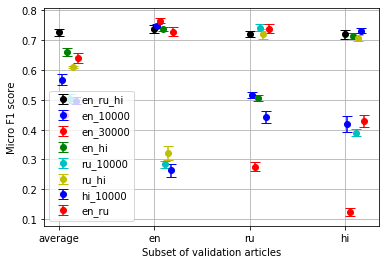

In [116]:
path_to_scores = Path(f"results/{metric_name}_scores/")
files_list = list(path_to_scores.iterdir())
model_to_mean_std = {}

[model_to_mean_std.update(torch.load(fname)) for fname in files_list]

create_plot(files_list, model_to_mean_std.keys(), "kbrgcybr")

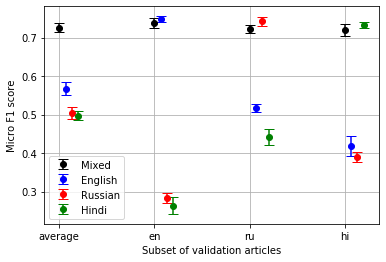

In [118]:
files_list = [
    'results/f1_micro_scores/en_ru_hi_mean_std.pt',
    'results/f1_micro_scores/en_10000_mean_std.pt',
    'results/f1_micro_scores/ru_10000_mean_std.pt',
    'results/f1_micro_scores/hi_10000_mean_std.pt',
]
model_names = [
    "Mixed",
    "English",
    "Russian",
    "Hindi",
]

create_plot(files_list, model_names, "kbrg")

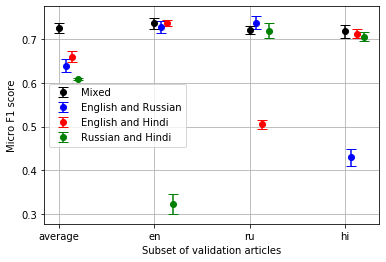

In [119]:
files_list = [
    'results/f1_micro_scores/en_ru_hi_mean_std.pt',
    'results/f1_micro_scores/en_ru_mean_std.pt',
    'results/f1_micro_scores/en_hi_mean_std.pt',
    'results/f1_micro_scores/ru_hi_mean_std.pt',
]
model_names = [
    "Mixed",
    "English and Russian",
    "English and Hindi",
    "Russian and Hindi",
]

create_plot(files_list, model_names, "kbrg")

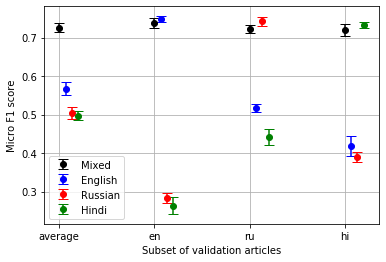

/scratch/mz2476/miniconda3/envs/my_base/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/scratch/mz2476/miniconda3/envs/my_base/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


,precision_macro,recall_macro,f1_macro,precision_micro,recall_micro,f1_micro
0,0.601943,0.474778,0.501424,0.806897,0.659155,0.725581
1,0.581520,0.475961,0.501708,0.798276,0.685926,0.737849
2,0.601665,0.457821,0.497679,0.795041,0.668056,0.726038


In [69]:
[np.arange(start, 100, num_splits) for start in range(num_splits)]

[array([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80,
        85, 90, 95]),
 array([ 1,  6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81,
        86, 91, 96]),
 array([ 2,  7, 12, 17, 22, 27, 32, 37, 42, 47, 52, 57, 62, 67, 72, 77, 82,
        87, 92, 97]),
 array([ 3,  8, 13, 18, 23, 28, 33, 38, 43, 48, 53, 58, 63, 68, 73, 78, 83,
        88, 93, 98]),
 array([ 4,  9, 14, 19, 24, 29, 34, 39, 44, 49, 54, 59, 64, 69, 74, 79, 84,
        89, 94, 99])]

In [64]:
indices = np.arange(500)
indices = np.arange(500, 1000)

dict_of_metrics = learner.get_test_metrics(
    data.Subset(learner.val_loader.dataset, indices), device=learner.device)

import pandas as pd

pd.DataFrame([dict_of_metrics, dict_of_metrics])

/scratch/mz2476/miniconda3/envs/my_base/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/scratch/mz2476/miniconda3/envs/my_base/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


,precision_macro,recall_macro,f1_macro,precision_micro,recall_micro,f1_micro
0,0.651972,0.482795,0.534985,0.798883,0.680304,0.734841
1,0.651972,0.482795,0.534985,0.798883,0.680304,0.734841


In [ ]:
# train the model
model_name = "mixed_en_hi_ru_" + "_".join([str(key) + "_" + str(value) for key, value in result.items()])
print(model_name)
metrics_dict = train_model(train_loader, val_loader, model, criterion, optimizer, options, device,
                num_epochs=10, model_name="model", save_model=False)
result.update(metrics_dict)

In [8]:
optimizer.param_groups[0]["lr"]

0.01

In [120]:
# loaders = create_data_loaders_for_model(wiki_loaders["train"], wiki_loaders["val"])
# # create dataloader
# wiki_loaders = {}


# for split, wiki_dataset in dict_wiki_tensor_dataset.items():
#     wiki_loaders[split] = DataLoader(
#         wiki_dataset, 
#         batch_size=batch_size, 
#         shuffle=True, 
#         collate_fn=partial(pad_collate_fn, word_to_index=word_to_index)
#     )


# train_model(
#     wiki_loaders, model, criterion, optimizer, options=options, num_epochs=num_epochs, 
#     model_name=model_name, save_model=SAVE_MODEL
# )

# results_df = results_df.append(result, ignore_index=True)
#     results_df.to_csv("results/results_tuning_2_3_layers_maxlen_500.csv"

## Combine logits from NLP and GraphSAGE

### NLP

In [124]:
from MY_PATHS import *

In [125]:
# Load train/val/test QIDs
wiki_df_train = torch.load(f"{PATH_TO_DATA_FOR_MODEL_FOLDER}df_wiki_monolingual_train_30000_en.pt")
wiki_df_val   = torch.load(f"{PATH_TO_DATA_FOR_MODEL_FOLDER}df_wiki_valid_1000_en.pt")
wiki_df_test  = torch.load(f"{PATH_TO_DATA_FOR_MODEL_FOLDER}df_wiki_test_en.pt")


In [ ]:
SAVE_MODEL = False

batch_size = 8
lr = 0.01
num_epochs = 10

options = {
    "VOCAB_SIZE": len(index_to_word),
    "dim_e": weights_matrix_ve.shape[1],
    "pretrained_embeddings": weights_matrix_ve,
    "num_layers": 2,
    "num_classes": len(classes),
    "mid_features": 150,
    "dropout_rate": 0.2,
    "activation": nn.ReLU(),
}
    
result = {
    "optimizer": "Adam", 
    "num_hidden": options["num_layers"],
    "dim_hidden": options["mid_features"],
    "dropout_rate": options["dropout_rate"],
    "learning_rate": lr,
    "num_epochs": num_epochs
}


print("\n", result)
model_name = "mixed_en_hi_ru_" + "_".join([str(key) + "_" + str(value) for key, value in result.items()])

learner = ClassifierLearner(options, model_name, device=device)

TRAIN_SET_NAME = "train_ru_hi"

val_keys = ["val_en", "val_ru", "val_hi", "val"]
train_loader, dict_val_loader = get_train_val_loader(
    dict_wiki_tensor_dataset[TRAIN_SET_NAME], 
    [dict_wiki_tensor_dataset[key] for key in val_keys], 
    collate_fn=partial(pad_collate_fn, pad_token=word_to_index["<pad>"])
)